# TF2 Example with new NFP layers

In [1]:
import nfp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

### Load the solubility dataset and split into train / test / valid sets

In [2]:
solubility = pd.read_csv('../data/delaney.csv')

# Split into train, dev, and test sets
train = solubility.sample(frac=.8, random_state=1)
valid = solubility[~solubility.index.isin(train.index)].sample(frac=.5, random_state=1)
test = solubility[~solubility.index.isin(train.index) & ~solubility.index.isin(valid.index)]

### Define some tensorflow boilerplate
I may move this inside nfp at some point.

In [4]:
import tensorflow as tf
from tqdm import tqdm

# Code from https://www.tensorflow.org/tutorials/load_data/tfrecord

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_value(value):
    if type(value) == np.ndarray:
        return _bytes_feature(tf.io.serialize_tensor(value))
    elif type(value) == int:
        return _int64_feature(value)
    elif type(value) == float:
        return _float_feature(value)
    else:
        raise TypeError

### Create the preprocessor
and define an iterator to yield input encodings and prediction targets

In [5]:
preprocessor = nfp.SmilesPreprocessor()
        
def inputs_generator(df, train=True):
    preprocessor.atom_tokenizer.train = train
    preprocessor.bond_tokenizer.train = train    
    for i, row in tqdm(df.iterrows()):
        input_dict = preprocessor.construct_feature_matrices(row.smiles)
        input_dict['solubility'] = row['measured log solubility in mols per litre']
        
        features = {key: serialize_value(val) for key, val in input_dict.items()}
        example_proto = tf.train.Example(features=tf.train.Features(feature=features))
        
        yield example_proto.SerializeToString()

### TFRecords preprocessing
I'm using the tfrecords file format to write the preprocessed train and validation inputs to disk.

This allows me to take a full pass over the training dataset to learn atom / bond types before looking at the validation set

In [6]:
# Preprocess and write the train dataset to disk
serialized_train_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(train, train=True),
    output_types=tf.string, output_shapes=())

filename = 'train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_train_dataset)

# Preprocess and write the validation dataset to disk
serialized_valid_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(valid, train=False),
    output_types=tf.string, output_shapes=())

filename = 'valid.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_valid_dataset)

902it [00:01, 895.18it/s]
113it [00:00, 886.56it/s]


In [7]:
preprocessor.max_atoms

119

In [8]:
preprocessor.max_bonds

126

### Load the dataset back from the tfrecord files
These functions load the saved data back from the disk, and batches and pads the resulting inputs.

TF's tfrecord format asks for some fairly verbose descriptions of the data types.

In [12]:
def parse_example(example):
    
    parsed = tf.io.parse_single_example(example, features={
        'n_atom': tf.io.FixedLenFeature([], dtype=tf.int64),
        'n_bond': tf.io.FixedLenFeature([], dtype=tf.int64),
        'bond_indices': tf.io.FixedLenFeature([], dtype=tf.string),
        'atom': tf.io.FixedLenFeature([], dtype=tf.string),
        'bond': tf.io.FixedLenFeature([], dtype=tf.string),
        'connectivity': tf.io.FixedLenFeature([], dtype=tf.string),
        'solubility': tf.io.FixedLenFeature([], dtype=tf.float32)})

    parsed['bond_indices'] = tf.io.parse_tensor(parsed['bond_indices'], out_type=tf.int64)
    parsed['atom'] = tf.io.parse_tensor(parsed['atom'], out_type=tf.int64)
    parsed['bond'] = tf.io.parse_tensor(parsed['bond'], out_type=tf.int64)
    parsed['connectivity'] = tf.io.parse_tensor(parsed['connectivity'], out_type=tf.int64)
    
    # Pop out the prediction target from the stored dictionary as a seperate input
    solubility = parsed.pop('solubility')
    
    return parsed, solubility

max_atoms = -1  # These allow prespecifying array shapes, i.e. for CUDA cores
max_bonds = -1

padded_shapes = ({'n_atom': [],
                  'n_bond': [],
                  'bond_indices': [max_bonds],            
                  'atom': [max_atoms],
                  'bond': [max_bonds],
                  'connectivity': [max_bonds, 2]},
                 [])

zero = tf.constant(0, dtype=tf.int64)
padding_values = ({'n_atom': zero,
                   'n_bond': zero,
                   'bond_indices': zero,
                   'atom': zero,
                   'bond': zero,
                   'connectivity': zero},
                  tf.constant(np.nan, dtype=tf.float32))

batch_size = 2**6

train_dataset = tf.data.TFRecordDataset('train.tfrecord')\
    .map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .cache().repeat().shuffle(buffer_size=500)\
    .padded_batch(batch_size=batch_size, padded_shapes=padded_shapes,
                  padding_values=padding_values)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.TFRecordDataset('valid.tfrecord')\
    .map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .cache().repeat().shuffle(buffer_size=500)\
    .padded_batch(batch_size=batch_size, padded_shapes=padded_shapes,
                  padding_values=padding_values)\
    .prefetch(tf.data.experimental.AUTOTUNE)

### Define the tf.keras model

Here's where I actually define the keras model. The new NFP layers are fairly basic 'Gather', 'Slice', and 'Reduce' layers, that I compose into these graph neural networks. They're a bit less fully-featured, but a lot more flexible for different architectures.

In [13]:
from tensorflow.keras import layers
import nfp

n_atom = layers.Input(shape=[], dtype=tf.int64, name='n_atom')
n_bond = layers.Input(shape=[], dtype=tf.int64, name='n_bond')
bond_indices = layers.Input(shape=[None], dtype=tf.int64, name='bond_indices')
atom_class = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond_class = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

input_tensors = [n_atom, n_bond, bond_indices, atom_class, bond_class, connectivity]

atom_features = 16
num_messages = 3

# Initialize the atom states
atom_state = layers.Embedding(preprocessor.atom_classes, atom_features,
                              name='atom_embedding', mask_zero=True)(atom_class)

# Initialize the bond states
bond_state = layers.Embedding(preprocessor.bond_classes, atom_features,
                              name='bond_embedding', mask_zero=True)(bond_class)

# Initialize the bond states
atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom_class)


def message_block(original_atom_state, original_bond_state, connectivity, i):
    
    atom_state = layers.LayerNormalization()(original_atom_state)
    bond_state = layers.LayerNormalization()(original_bond_state)
    
    source_atom = nfp.Gather()([atom_state, nfp.Slice(np.s_[:, :, 1])(connectivity)])
    target_atom = nfp.Gather()([atom_state, nfp.Slice(np.s_[:, :, 0])(connectivity)])

    # Edge update network
    new_bond_state = layers.Concatenate(name='concat_{}'.format(i))(
        [source_atom, target_atom, bond_state])
    new_bond_state = layers.Dense(
        2*atom_features, activation='relu')(new_bond_state)
    new_bond_state = layers.Dense(atom_features)(new_bond_state)

    bond_state = layers.Add()([original_bond_state, new_bond_state])

    # message function
    source_atom = layers.Dense(atom_features)(source_atom)    
    messages = layers.Multiply()([source_atom, bond_state])
    messages = nfp.Reduce(reduction='sum')(
        [messages, nfp.Slice(np.s_[:, :, 0])(connectivity), atom_state])
    
    # state transition function
    messages = layers.Dense(atom_features, activation='relu')(messages)
    messages = layers.Dense(atom_features)(messages)
    
    atom_state = layers.Add()([original_atom_state, messages])
    
    return atom_state, bond_state

for i in range(num_messages):
    atom_state, bond_state = message_block(atom_state, bond_state, connectivity, i)
    
atom_state = layers.Dense(1)(atom_state)
atom_state = layers.Add()([atom_state, atom_mean])

averaged_solubility = tf.keras.layers.GlobalAveragePooling1D()(atom_state)

model = tf.keras.Model(input_tensors, [averaged_solubility])
model.compile(loss=nfp.masked_mean_absolute_error, optimizer=tf.keras.optimizers.Adam(3E-4))

In [14]:
hist = model.fit(train_dataset, validation_data=valid_dataset, epochs=50,
                 steps_per_epoch=len(train) // batch_size,
                 validation_steps=len(valid) // batch_size, verbose=2)

Train for 14 steps, validate for 1 steps
Epoch 1/50
14/14 - 6s - loss: 2.0290 - val_loss: 1.6047
Epoch 2/50
14/14 - 0s - loss: 1.3893 - val_loss: 1.4492
Epoch 3/50
14/14 - 0s - loss: 1.3755 - val_loss: 1.1301
Epoch 4/50
14/14 - 0s - loss: 1.1544 - val_loss: 1.2164
Epoch 5/50
14/14 - 0s - loss: 1.1817 - val_loss: 0.9521
Epoch 6/50
14/14 - 0s - loss: 1.0862 - val_loss: 1.0091
Epoch 7/50
14/14 - 0s - loss: 1.0621 - val_loss: 0.8454
Epoch 8/50
14/14 - 0s - loss: 1.0413 - val_loss: 0.9067
Epoch 9/50
14/14 - 0s - loss: 1.0114 - val_loss: 0.8853
Epoch 10/50
14/14 - 0s - loss: 0.9550 - val_loss: 0.8118
Epoch 11/50
14/14 - 0s - loss: 0.9228 - val_loss: 0.7173
Epoch 12/50
14/14 - 0s - loss: 0.9065 - val_loss: 0.7539
Epoch 13/50
14/14 - 0s - loss: 0.8924 - val_loss: 0.7379
Epoch 14/50
14/14 - 0s - loss: 0.8709 - val_loss: 0.7388
Epoch 15/50
14/14 - 0s - loss: 0.8905 - val_loss: 0.7896
Epoch 16/50
14/14 - 0s - loss: 0.8546 - val_loss: 0.7882
Epoch 17/50
14/14 - 0s - loss: 0.8625 - val_loss: 0.8796

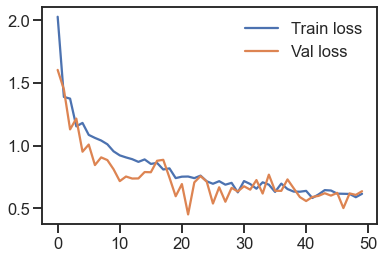

In [15]:
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Val loss')
plt.legend()

### Model predictions

Here I simulate wanting to re-load a trained model in another script. This saves both the preprocessor (for remembering how to convert atoms and bonds to their classes) as well as the trained model weights and structure.

In [16]:
model.save('model.h5')

import pickle
with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

In [17]:
# Just to show these are created again
del model
del preprocessor

In [18]:
model = tf.keras.models.load_model('model.h5', custom_objects=nfp.custom_objects)
with open('preprocessor.p', 'rb') as f:
    preprocessor = pickle.load(f)

Here I show a slightly different dataset approach that doesn't use TFRecords, in case this is done for interactive predictions of new molecules where round-tripping a binary file doesn't make sense

In [19]:
def test_generator(smiles):
    preprocessor.atom_tokenizer.train = False
    preprocessor.bond_tokenizer.train = False    
    for smiles in tqdm(smiles):
        yield preprocessor.construct_feature_matrices(smiles)

In [20]:
output_types = {'n_atom': tf.int64,
                'n_bond': tf.int64,
                'bond_indices': tf.int64,            
                'atom': tf.int64,
                'bond': tf.int64,
                'connectivity': tf.int64}

output_shapes = {'n_atom': tf.TensorShape([]),
                 'n_bond': tf.TensorShape([]),
                 'bond_indices': tf.TensorShape([None]),            
                 'atom': tf.TensorShape([None]),
                 'bond': tf.TensorShape([None]),
                 'connectivity': tf.TensorShape([None, None])}
       
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator(test.smiles),
    output_types=output_types, output_shapes=output_shapes)\
    .padded_batch(batch_size=batch_size, padded_shapes=padded_shapes[0],
                  padding_values=padding_values[0])

In [ ]:
predictions = model.predict(test_dataset)

 92%|█████████▏| 104/113 [00:01<00:06,  1.44it/s]

In [ ]:
plt.plot(predictions, test['measured log solubility in mols per litre'], '.')
plt.plot([-10, 2], [-10, 2], '--', color='.7')
mae = (predictions.squeeze() - test['measured log solubility in mols per litre']).abs().mean()
plt.title(f'Test MAE: {mae:.3f}')